Get fields from Lumerical and save in file for later

NOTE: On this file I look for the first 6 modes, regardless of their type.

In [1]:
import lumerical as lum
import numpy as  np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import imp
import time
import matplotlib.patches as patches

np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

In [2]:
lumapi = imp.load_source("lumapi", "C:/Program Files/Lumerical/2020a/api/python/lumapi.py")
MODE = lumapi.MODE("Template_Luis.lms")

Units

In [3]:
from scipy.constants import pi, c
um = 1e-6
nm = 1e-9
THz = 1e12

Materials

In [4]:
material_substrate = "SiO2_analytic"
material_thinfilm = "LN_analytic_MgO_doped_xne"

Main waveguide parameters

slab = 0.350 um
width at the base = 1.404 um


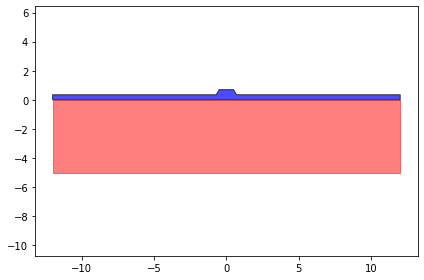

In [5]:
h_LN = 700*nm
h_etch = 350*nm
width_top = 1000*nm
theta = 60
h_slab = h_LN - h_etch

w_slab = 24*um
h_margin = 5*um
h_substrate = 5*um
meshsize = 50*nm
finemesh = 20*nm

wg_length = 10*um #Useless in MODE
width_top_base = width_top + 2*h_etch/np.tan(theta*pi/180)
w_sidewall = h_etch/np.tan(theta*pi/180)

print('slab = %.3f um' %(h_slab/um))
print('width at the base = %.3f um' %(width_top_base/um))

#Draw it
fig,ax = plt.subplots()
substrate = patches.Rectangle((-w_slab/2/um,-h_substrate/um), w_slab/um, h_substrate/um,
                             linewidth=1, edgecolor='r', facecolor='r', alpha=0.5)
v_ridge = np.array([[-width_top/2-w_sidewall,h_slab], [-width_top/2,h_LN],
                   [width_top/2,h_LN], [width_top/2+w_sidewall,h_slab],
                   [w_slab/2,h_slab], [w_slab/2,0], 
                   [-w_slab/2,0], [-w_slab/2, h_slab] ] )/um
ridge = patches.Polygon(v_ridge, linewidth=1, 
                       edgecolor='k', facecolor='blue', alpha=0.7)

ax.add_patch(substrate)
ax.add_patch(ridge)

plt.axis('equal')
plt.tight_layout()
plt.show()

Wavelength range

In [6]:
wl_start = 0.6*um
wl_stop = 5*um
f_start = c/wl_stop
f_stop = c/wl_start
f_step = 10*THz

freqs = np.arange(f_start, f_stop+1*THz, f_step)
wl = c/freqs

print('Lowest frequency = %0.1f THz (%0.1f um)' %(f_start/THz, wl_stop/um))
print('Highest frequency = %0.1f THz (%0.1f um)' %(f_stop/THz, wl_start/um))
print('')
print('Frequency list (THz)', (freqs/THz))
print('')
print('Wavelength list =', wl/um, ' um')

Lowest frequency = 60.0 THz (5.0 um)
Highest frequency = 499.7 THz (0.6 um)

Frequency list (THz) [ 59.958  69.958  79.958  89.958  99.958  109.958  119.958  129.958
  139.958  149.958  159.958  169.958  179.958  189.958  199.958  209.958
  219.958  229.958  239.958  249.958  259.958  269.958  279.958  289.958
  299.958  309.958  319.958  329.958  339.958  349.958  359.958  369.958
  379.958  389.958  399.958  409.958  419.958  429.958  439.958  449.958
  459.958  469.958  479.958  489.958  499.958]

Wavelength list = [ 5.000  4.285  3.749  3.333  2.999  2.726  2.499  2.307  2.142  1.999
  1.874  1.764  1.666  1.578  1.499  1.428  1.363  1.304  1.249  1.199
  1.153  1.111  1.071  1.034  0.999  0.967  0.937  0.909  0.882  0.857
  0.833  0.810  0.789  0.769  0.750  0.731  0.714  0.697  0.681  0.666
  0.652  0.638  0.625  0.612  0.600]  um


Draw waveguide and setup solver

In [7]:
lum.draw_wg(MODE, material_thinfilm, material_substrate,
              h_LN, h_substrate, h_etch, width_top, w_slab, theta, wg_length)
lum.add_fine_mesh(MODE, finemesh, h_LN, width_top_base, x_factor=1.2, y_factor=1.5)
lum.add_2D_mode_solver(MODE, meshsize, h_LN, h_substrate, 
                         w_slab, wg_length, h_margin)

In [8]:
nmodes = 6 #will save first 6 modes only

modes = np.empty( (wl.size, nmodes), dtype=object)
neff = np.empty( (wl.size, nmodes) )
ng = np.empty( (wl.size, nmodes) )
loss = np.empty( (wl.size, nmodes) )
tepf = np.empty( (wl.size, nmodes) )

neff[:] = np.nan
ng[:] = np.nan
loss[:] = np.nan
tepf[:] = np.nan

tic = time.time()
for kw in range(wl.size):
    MODE.switchtolayout()
    _neff, _ng, _loss, _tepf = lum.solve_mode(MODE, wl[kw], nmodes=10)
    
    m = min(_ng.size, nmodes)
    
    for km in range(m): #Look for first the first four modes

        if _loss[km]<1e-5:
            M = lum.mode()
            M.get_from_lumerical(MODE, km+1)
            modes[kw, km] = M
            neff[kw, km] = _neff[km]
            ng[kw, km]   = _ng[km]
            loss[kw, km] = _loss[km]
            tepf[kw, km] = _tepf[km]

    print('Wavelength %0.3f um completed' %(wl[kw]/um))
    
MODE.close()
total_time = (time.time() - tic)/60
print('Total time = %.1f  min' %(total_time))

#Save data
data_filename = 'Data\LNoI_%inm_%inm_%inm' %(int(h_LN/nm), int(h_etch/nm), 
                                                                int(width_top/nm))
data_filename = data_filename.replace('.','p')
np.savez(data_filename, modes=modes, neff=neff, ng=ng, loss=loss, tepf=tepf, wavelength=wl, #Main results
         h_LN=h_LN, h_etch=h_etch, width_top=width_top, #Setup stuff
         theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
         meshsize=meshsize, finemesh=finemesh, 
         material_substrate=material_substrate, material_thinfilm=material_thinfilm)

Wavelength 5.000 um completed
Wavelength 4.285 um completed
Wavelength 3.749 um completed
Wavelength 3.333 um completed
Wavelength 2.999 um completed
Wavelength 2.726 um completed
Wavelength 2.499 um completed
Wavelength 2.307 um completed
Wavelength 2.142 um completed
Wavelength 1.999 um completed
Wavelength 1.874 um completed
Wavelength 1.764 um completed
Wavelength 1.666 um completed
Wavelength 1.578 um completed
Wavelength 1.499 um completed
Wavelength 1.428 um completed
Wavelength 1.363 um completed
Wavelength 1.304 um completed
Wavelength 1.249 um completed
Wavelength 1.199 um completed
Wavelength 1.153 um completed
Wavelength 1.111 um completed
Wavelength 1.071 um completed
Wavelength 1.034 um completed
Wavelength 0.999 um completed
Wavelength 0.967 um completed
Wavelength 0.937 um completed
Wavelength 0.909 um completed
Wavelength 0.882 um completed
Wavelength 0.857 um completed
Wavelength 0.833 um completed
Wavelength 0.810 um completed
Wavelength 0.789 um completed
Wavelength

In [9]:
data_filename = 'Data\LNoI_%inm_%inm_%inm' %(int(h_LN/nm), int(h_etch/nm), 
                                                                int(width_top/nm))
data_filename = data_filename.replace('.','p')
np.savez(data_filename, modes=modes, neff=neff, ng=ng, loss=loss, tepf=tepf, wavelength=wl, #Main results
         h_LN=h_LN, h_etch=h_etch, width_top=width_top, #Setup stuff
         theta=theta, h_substrate=h_substrate, w_slab=w_slab, h_margin=h_margin, 
         meshsize=meshsize, finemesh=finemesh, 
         material_substrate=material_substrate, material_thinfilm=material_thinfilm)

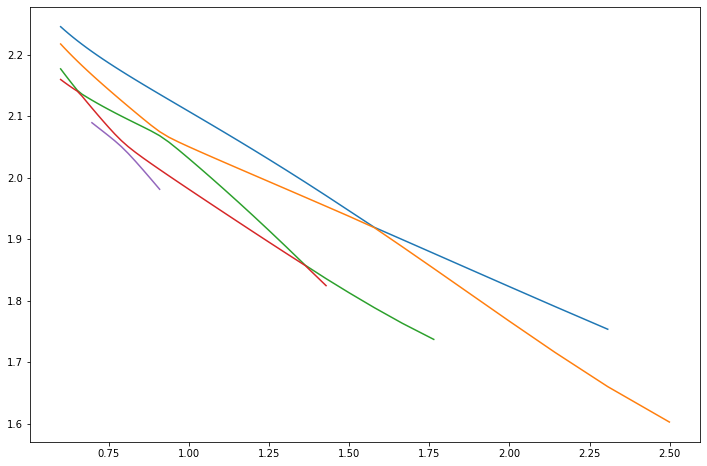

In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(wl/um, neff)

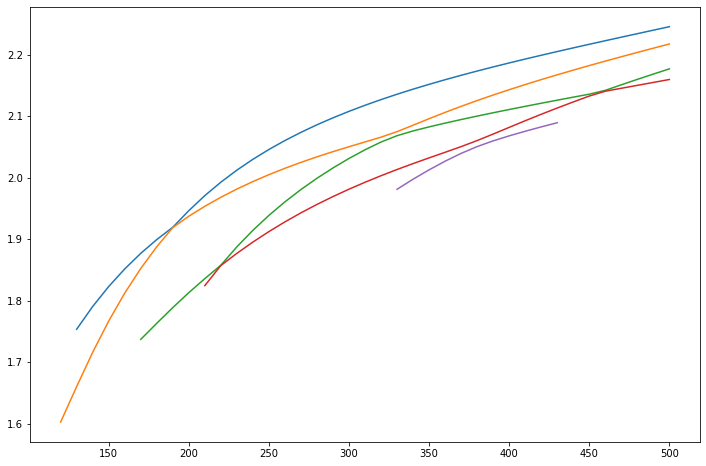

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.plot(freqs/THz, neff)

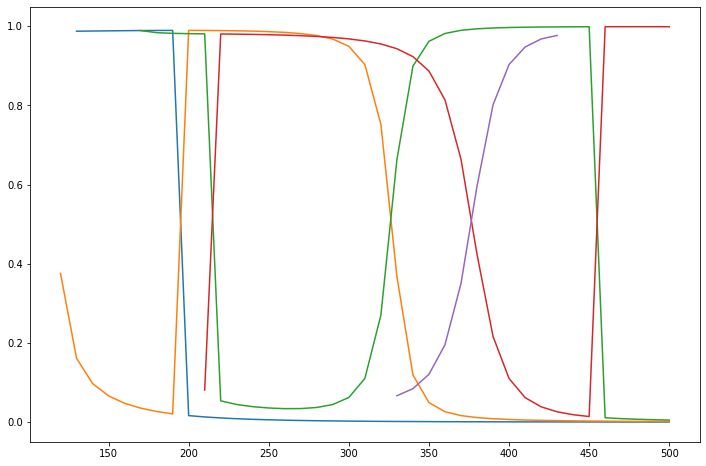

In [12]:
plt.plot(freqs/THz, tepf)